In [90]:
import numpy as np
import matplotlib.pyplot as plt
from gymnasium import spaces
from tqdm import tqdm
from matplotlib.axes import Axes
from matplotlib.figure import Figure

<h1> How convergence to mean is affected by LR, number of samples and most importantly variance of a Gaussian sampled variable?</h1>

<h4>Note that the theta at any time t is an estimate of the mean E[y].</h4>

In [ ]:
fig: Figure = plt.figure()
ax: Axes = fig.subplots()
num_points = 10000
y = np.random.randn(num_points) * 0.1
x = np.arange(num_points)
theta_plt = []
theta = 10
for i in range(num_points):
    theta = theta + 0.1 * (y[i] - theta)
    theta_plt.append(theta)
ax.plot(x, theta_plt)

<h1> Cliff Environment </h1>

In [ ]:

from gymnasium.wrappers.compatibility import LegacyEnv


class CliffEnv(LegacyEnv):
    def __init__(self):
        self.height = 4
        self.width = 12
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(self.height),
            spaces.Discrete(self.width)
        ))
        self.moves = {
            0: (-1, 0),  # up
            1: (0, 1),  # right
            2: (1, 0),  # down
            3: (0, -1),  # left
        }

        # begin in start state
        self.reset()

    def step(self, action):
        x, y = self.moves[action]
        self.S = self.S[0] + x, self.S[1] + y

        self.S = max(0, self.S[0]), max(0, self.S[1])
        self.S = (min(self.S[0], self.height - 1),
                  min(self.S[1], self.width - 1))

        if self.S == (self.height - 1, self.width - 1):
            return self.S, -1, True, {}
        elif self.S[1] != 0 and self.S[0] == self.height - 1:
            return self.reset(), -100, False, {}
        return self.S, -1, False, {}

    def reset(self):
        self.S = (3, 0)
        return self.S


env = CliffEnv()

<h1> SARSA </h1>

In [ ]:
q = np.zeros((env.height, env.width, env.action_space.n))
epsilon = 0.1
alpha = 0.1
ep_lens = []
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
ax.set_ylim(0, 100)
for i in range(500):
    x, y, *_ = env.reset()
    done = False
    ep_len = 0
    action = env.action_space.sample()
    while not done:
        (x_, y_), reward, done, *_ = env.step(action)
        if np.random.rand() < epsilon:
            action_ = env.action_space.sample()
        else:
            action_ = np.argmax(q[x_][y_])
        ep_len += 1
        if not done:
            q[x][y][action] = q[x][y][action] + alpha * (reward + q[x_][y_][action_] - q[x][y][action])
        else:
            q[x][y][action] = q[x][y][action] + alpha * (reward - q[x][y][action])
        x, y = x_, y_
        action = action_
    ep_lens.append(ep_len)
    plt.plot(ep_lens)



In [ ]:
ep_len = 0
x, y, *_ = env.reset()
for i in range(100):
    action = np.argmax(q[x][y])
    (x_, y_), reward, done, *_ = env.step(action)
    ep_len += 1
    x, y = x_, y_
    if done:
        break
print("Eval ep len=", ep_len)

<h1> Q-learning </h1>

In [ ]:
q = np.zeros((env.height, env.width, env.action_space.n))
alpha = 0.1
ep_lens = []
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 1, 1)
for i in range(500):
    x, y, *_ = env.reset()
    done = False
    ep_len = 0
    while not done:
        action = env.action_space.sample()
        (x_, y_), reward, done, *_ = env.step(action)
        action_ = np.argmax(q[x_][y_])
        ep_len += 1
        if not done:
            q[x][y][action] = q[x][y][action] + alpha * (reward + q[x_][y_][action_] - q[x][y][action])
        else:
            q[x][y][action] = q[x][y][action] + alpha * (reward - q[x][y][action])
        x, y = x_, y_
    ep_lens.append(ep_len)
    plt.plot(ep_lens)



In [ ]:
ep_len = 0
x, y, *_ = env.reset()
for i in range(100):
    action = np.argmax(q[x][y])
    (x_, y_), reward, done, *_ = env.step(action)
    ep_len += 1
    x, y = x_, y_
    if done:
        break
print("Eval ep len=", ep_len)

<h1> Policy Gradient - REINFORCE with batch size of 25 for faster learning </h1>

In [137]:
class PomdpGrid:
    def __init__(self):
        self.s = None
    def step(self,action):
        match self.s:
            case 0:
                self.s+= action
            case 1:
                self.s += -1 if action == 1 else 1
            case 2:
                self.s+= 1 if action == 1 else -1
        return 0 if self.s==3 else -1, self.s == 3
    
    def reset(self):
        self.s = 0
        return self.s
            

In [230]:
np.random.seed(10)
NUM_TRIALS = 100
NUM_EPISODES = 1000 
BATCH_SIZE = 25
env = PomdpGrid()
ALPHA = 10e-4
returns = np.zeros(shape=(NUM_TRIALS,NUM_EPISODES))
x = np.array([[0,1],[1,0]])
def pmf():
    h = np.dot(theta, x)
    t = np.exp(h - np.max(h))
    p = t / np.sum(t)
    imin = np.argmin(p)
    epsilon = 0.05
    if p[imin] < epsilon:
        p[:] = 1 - epsilon
        p[imin] = epsilon
    return p


for trial in range(NUM_TRIALS):
    rewards = []
    theta = np.array([1.47,-1.47])
    for i in tqdm(range(NUM_EPISODES)):
        env.reset()
        experiences = []
        ret = 0
        while True:
            action = 1 if np.random.uniform() <= pmf()[1] else 0
            reward,terminated = env.step(action)
            experiences.append((action,reward))
            ret+=reward
            if terminated:
                break
        rewards.append(ret)
        #print("\rP(right)=",pmf(1),"theta0=",theta0,"theta1=",theta1,"ret=",ret,end="")
        for j in np.arange(0,len(experiences),BATCH_SIZE):
            grad = 0
            for k in range(min(BATCH_SIZE,len(experiences) - j)):
                experience = experiences[j+k]
                action = experience[0]
                grad += ret*(x[:,action] - np.dot(x,pmf()))
                ret-=experience[1]
            theta+= ALPHA*grad
    returns[trial,:] = rewards
        

100%|██████████| 1000/1000 [00:00<00:00, 4822.19it/s]


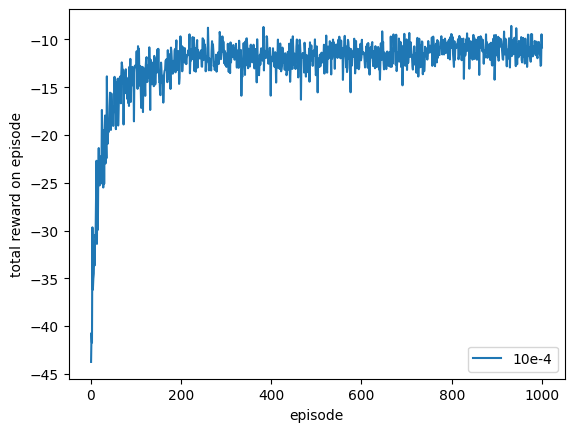

In [231]:
plt.plot(np.arange(NUM_EPISODES)+1,np.mean(returns,0),label="10e-4")
plt.legend(loc="lower right")
plt.ylabel('total reward on episode')
plt.xlabel('episode');

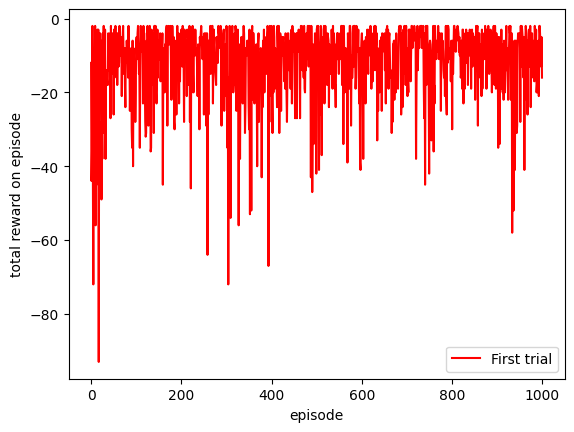

In [232]:
plt.plot(returns[0],label="First trial",color="red")
plt.legend(loc="lower right")
plt.ylabel('total reward on episode')
plt.xlabel('episode');